<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Probability And Statistics For Everyone</h1>
        <h1>A/B Testing</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

from scipy import stats
from sklearn.linear_model import LinearRegression

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.20
IPython version      : 8.12.3

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9e94ce594ca5c9d34f2d000df98ebf898ed5482a

matplotlib: 3.7.5
networkx  : 3.1
numpy     : 1.24.4
pandas    : 2.0.3
scipy     : 1.10.1
sklearn   : 1.3.2
watermark : 2.6.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Hypothesis Testing

### Simulated data

In [4]:
def get_data(N, pA, pB, fraction=0.5):
    df = pd.DataFrame({'group': (np.random.random(N)<(1-fraction)).astype('int'), 'conversion': 0})
    counts = df.groupby('group').count()
    
    NA = counts.loc[0, 'conversion']
    NB = counts.loc[1, 'conversion']
    
    df.loc[df['group']==0, 'conversion'] = (np.random.random(NA) < pA).astype('int')
    df.loc[df['group']==1, 'conversion'] = (np.random.random(NB) < pB).astype('int')    

    return df

Let's generate some random data. We're assuming two groups of users (chosen at random with probability $1/2$). The first group (control) has a conversion probability $p_A=5\%$ and the new group has a conversion probability $p_B=7.5\%$

In [5]:
pA_theory = 0.05
pB_theory = 0.075
N = 2000
data = get_data(N, pA_theory, pB_theory)

In [6]:
data

,group,conversion
0,1,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
1995,0,1
1996,0,0
1997,1,0
1998,0,0


### Group averages

conversion=1 means that they bought our product, while conversion=0 means they didn't. We can check how many users we have in each group

In [7]:
counts = data.groupby('group').count()
counts

,conversion
group,
0,976
1,1024


And the fraction that converted within each group

In [8]:
means = data.groupby('group').mean()
(means*100).round(2)

,conversion
group,
0,5.43
1,8.20


The conversion fractions are different from the theoretical ones. We can assume that each conversion is an independent process (similar to a coin flip), in which case, we expect that the observed values follow a Binomial distribution.

### Hypothesis Testing

/var/folders/lr/j1bs1q851k15cj5y777nxwph0000gn/T/ipykernel_73959/3431873838.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.plot(x, yA, label=r'$p_A=%1.3f$' % means.iloc[0])
/var/folders/lr/j1bs1q851k15cj5y777nxwph0000gn/T/ipykernel_73959/3431873838.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.plot(x, yB, label=r'$p_B=%1.3f$' % means.iloc[1])


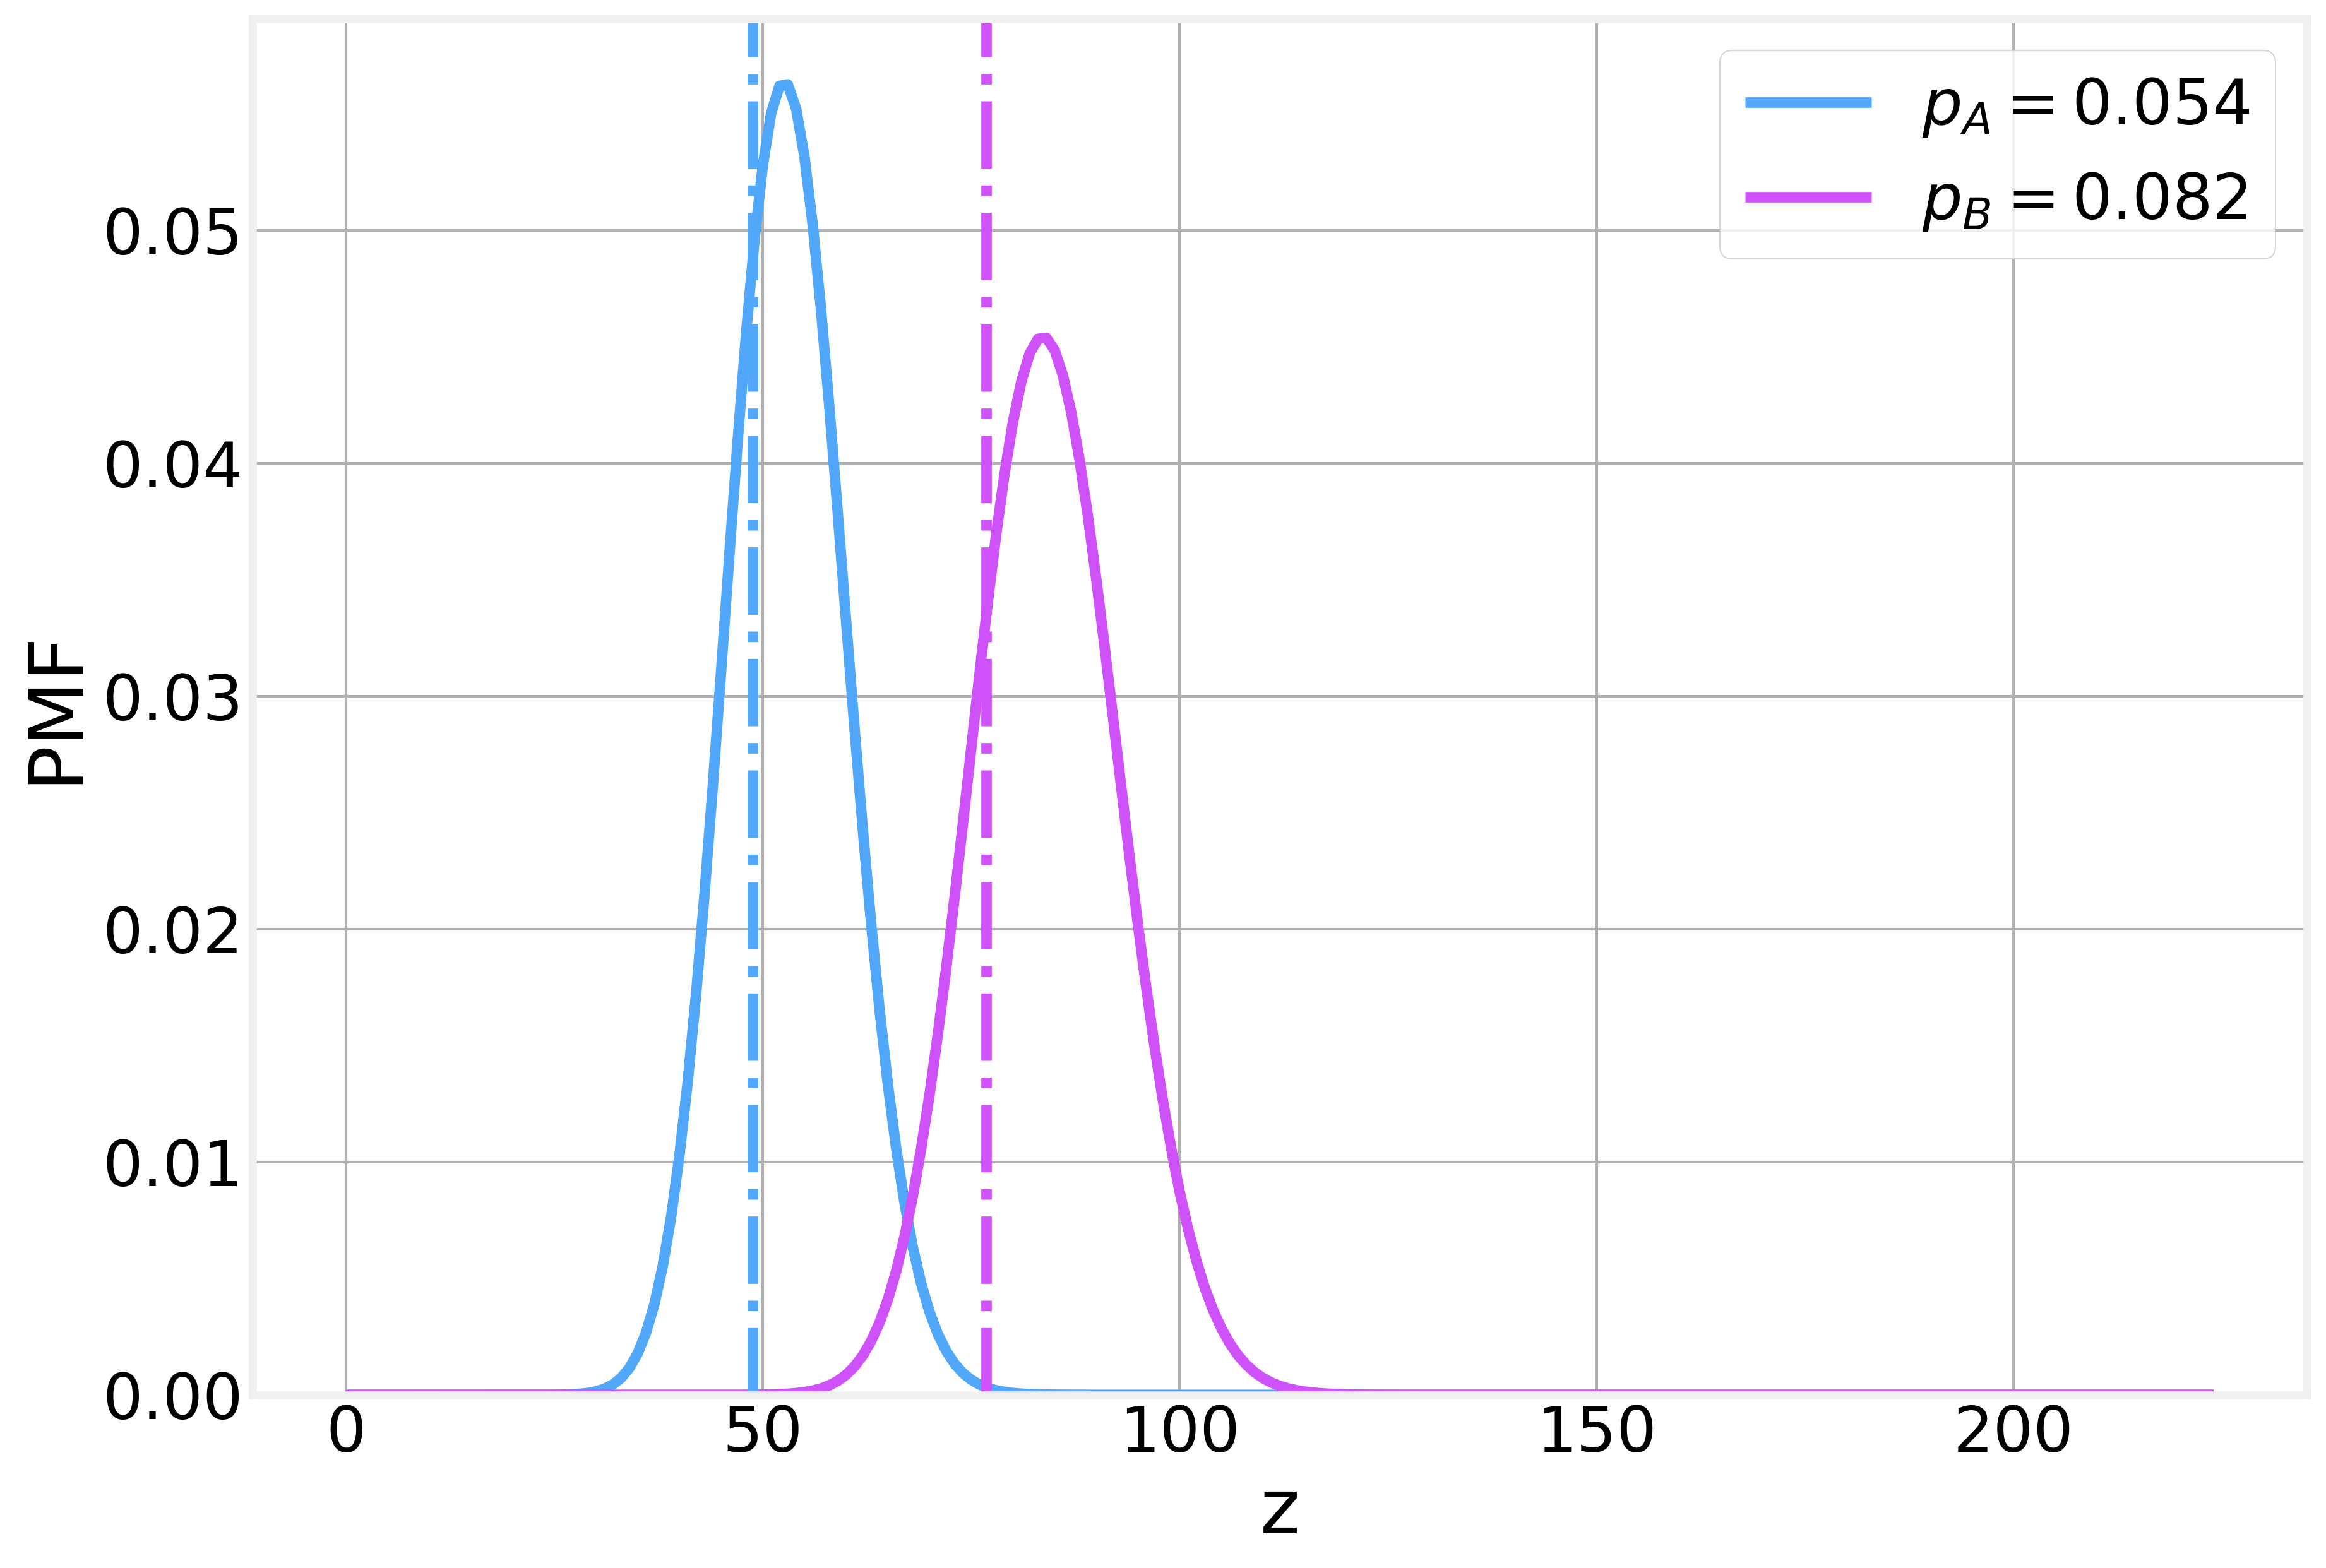

In [9]:
fig, ax = plt.subplots(1, 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.set_xlabel('z')
ax.set_ylabel('PMF')

x = np.arange(0, N*pB_theory*1.5)
yA = stats.binom(n=counts.iloc[0, 0], p=means.iloc[0, 0]).pmf(x)
ax.plot(x, yA, label=r'$p_A=%1.3f$' % means.iloc[0])

yB = stats.binom(n=counts.iloc[1, 0], p=means.iloc[1, 0]).pmf(x)
ax.plot(x, yB, label=r'$p_B=%1.3f$' % means.iloc[1])

height = np.max([yA.max(), yB.max()])*1.05

ax.vlines(x=[pA_theory*counts.iloc[0], pB_theory*counts.iloc[1]], 
          ymin=0, ymax=height, colors=colors[:2], linestyles='-.')
ax.set_ylim(0, height)
plt.legend()

This figure clearly illustrates that the observed number of conversions can be significantly differnet from the one we might expect theoretically (as represented by the dashed lines). Indeed, we can take the observed value as an "experimental measurement" of the true value. 

From the central limit theorem, we know that the difference between the true and the experimental values follows a gaussian distribution centered at zero and with a standard deviation given by the standard error of the meaurement. For a Bernoulli process, the standard error is given by

$$SE=\sqrt{\frac{p\left(1-p\right)}{N}}$$

In [10]:
pA = means.iloc[0]
NA = counts.iloc[0]
SEA = np.sqrt(pA*(1-pA)/NA)

pB = means.iloc[1]
NB = counts.iloc[1]
SEB = np.sqrt(pB*(1-pB)/NB)

The corresponding Z score is then given by:

$$Z=\frac{p_B-p_A}{\sqrt{SE_A^2+SE_B^2}}$$

In [11]:
def zscore(pA, pB, NA, NB):
    SEA = np.sqrt(pA*(1-pA)/NA)
    SEB = np.sqrt(pB*(1-pB)/NB)
    return ((pB-pA)/np.sqrt(SEA**2+SEB**2)).values[0]

The Z score for our example is then:

In [12]:
Z = zscore(pA, pB, NA, NB)
print(Z)

2.4686911620099643


We know that Z scores follow a normal distribution centered at zero and unity width. We can use this to calculate the p-values

In [13]:
def pvalue(zscore=2):
    return 1-stats.norm.cdf(zscore)

In [14]:
p = pvalue(Z)
print(p)

0.006780409972214407


We can get an intuitive view of the meaning of the p-value by plotting it in the z-score curve

In [15]:
def plot_zscore(zscore=2):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    norm = stats.norm()
    
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)
    height = y.max()
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y)
    ax.set_xlabel('z')
    ax.set_ylabel('PDF')
    
    p = pvalue(zscore)

    ax.vlines(zscore, 0, height, color=colors[1], linestyle='--')
    ax.text(zscore*1.05, height, "z=%1.2f" % zscore, va="top", ha="left")
    ax.text(zscore*1.05, height*.9, "p=%1.2g" % p, va="top", ha="left")

    selected = x > zscore
    
    ax.fill_between(x, 0, y, color=colors[2], alpha=0.4, where=selected)    
    ax.text(0, height/2, np.round(1-p, 5), ha='center')

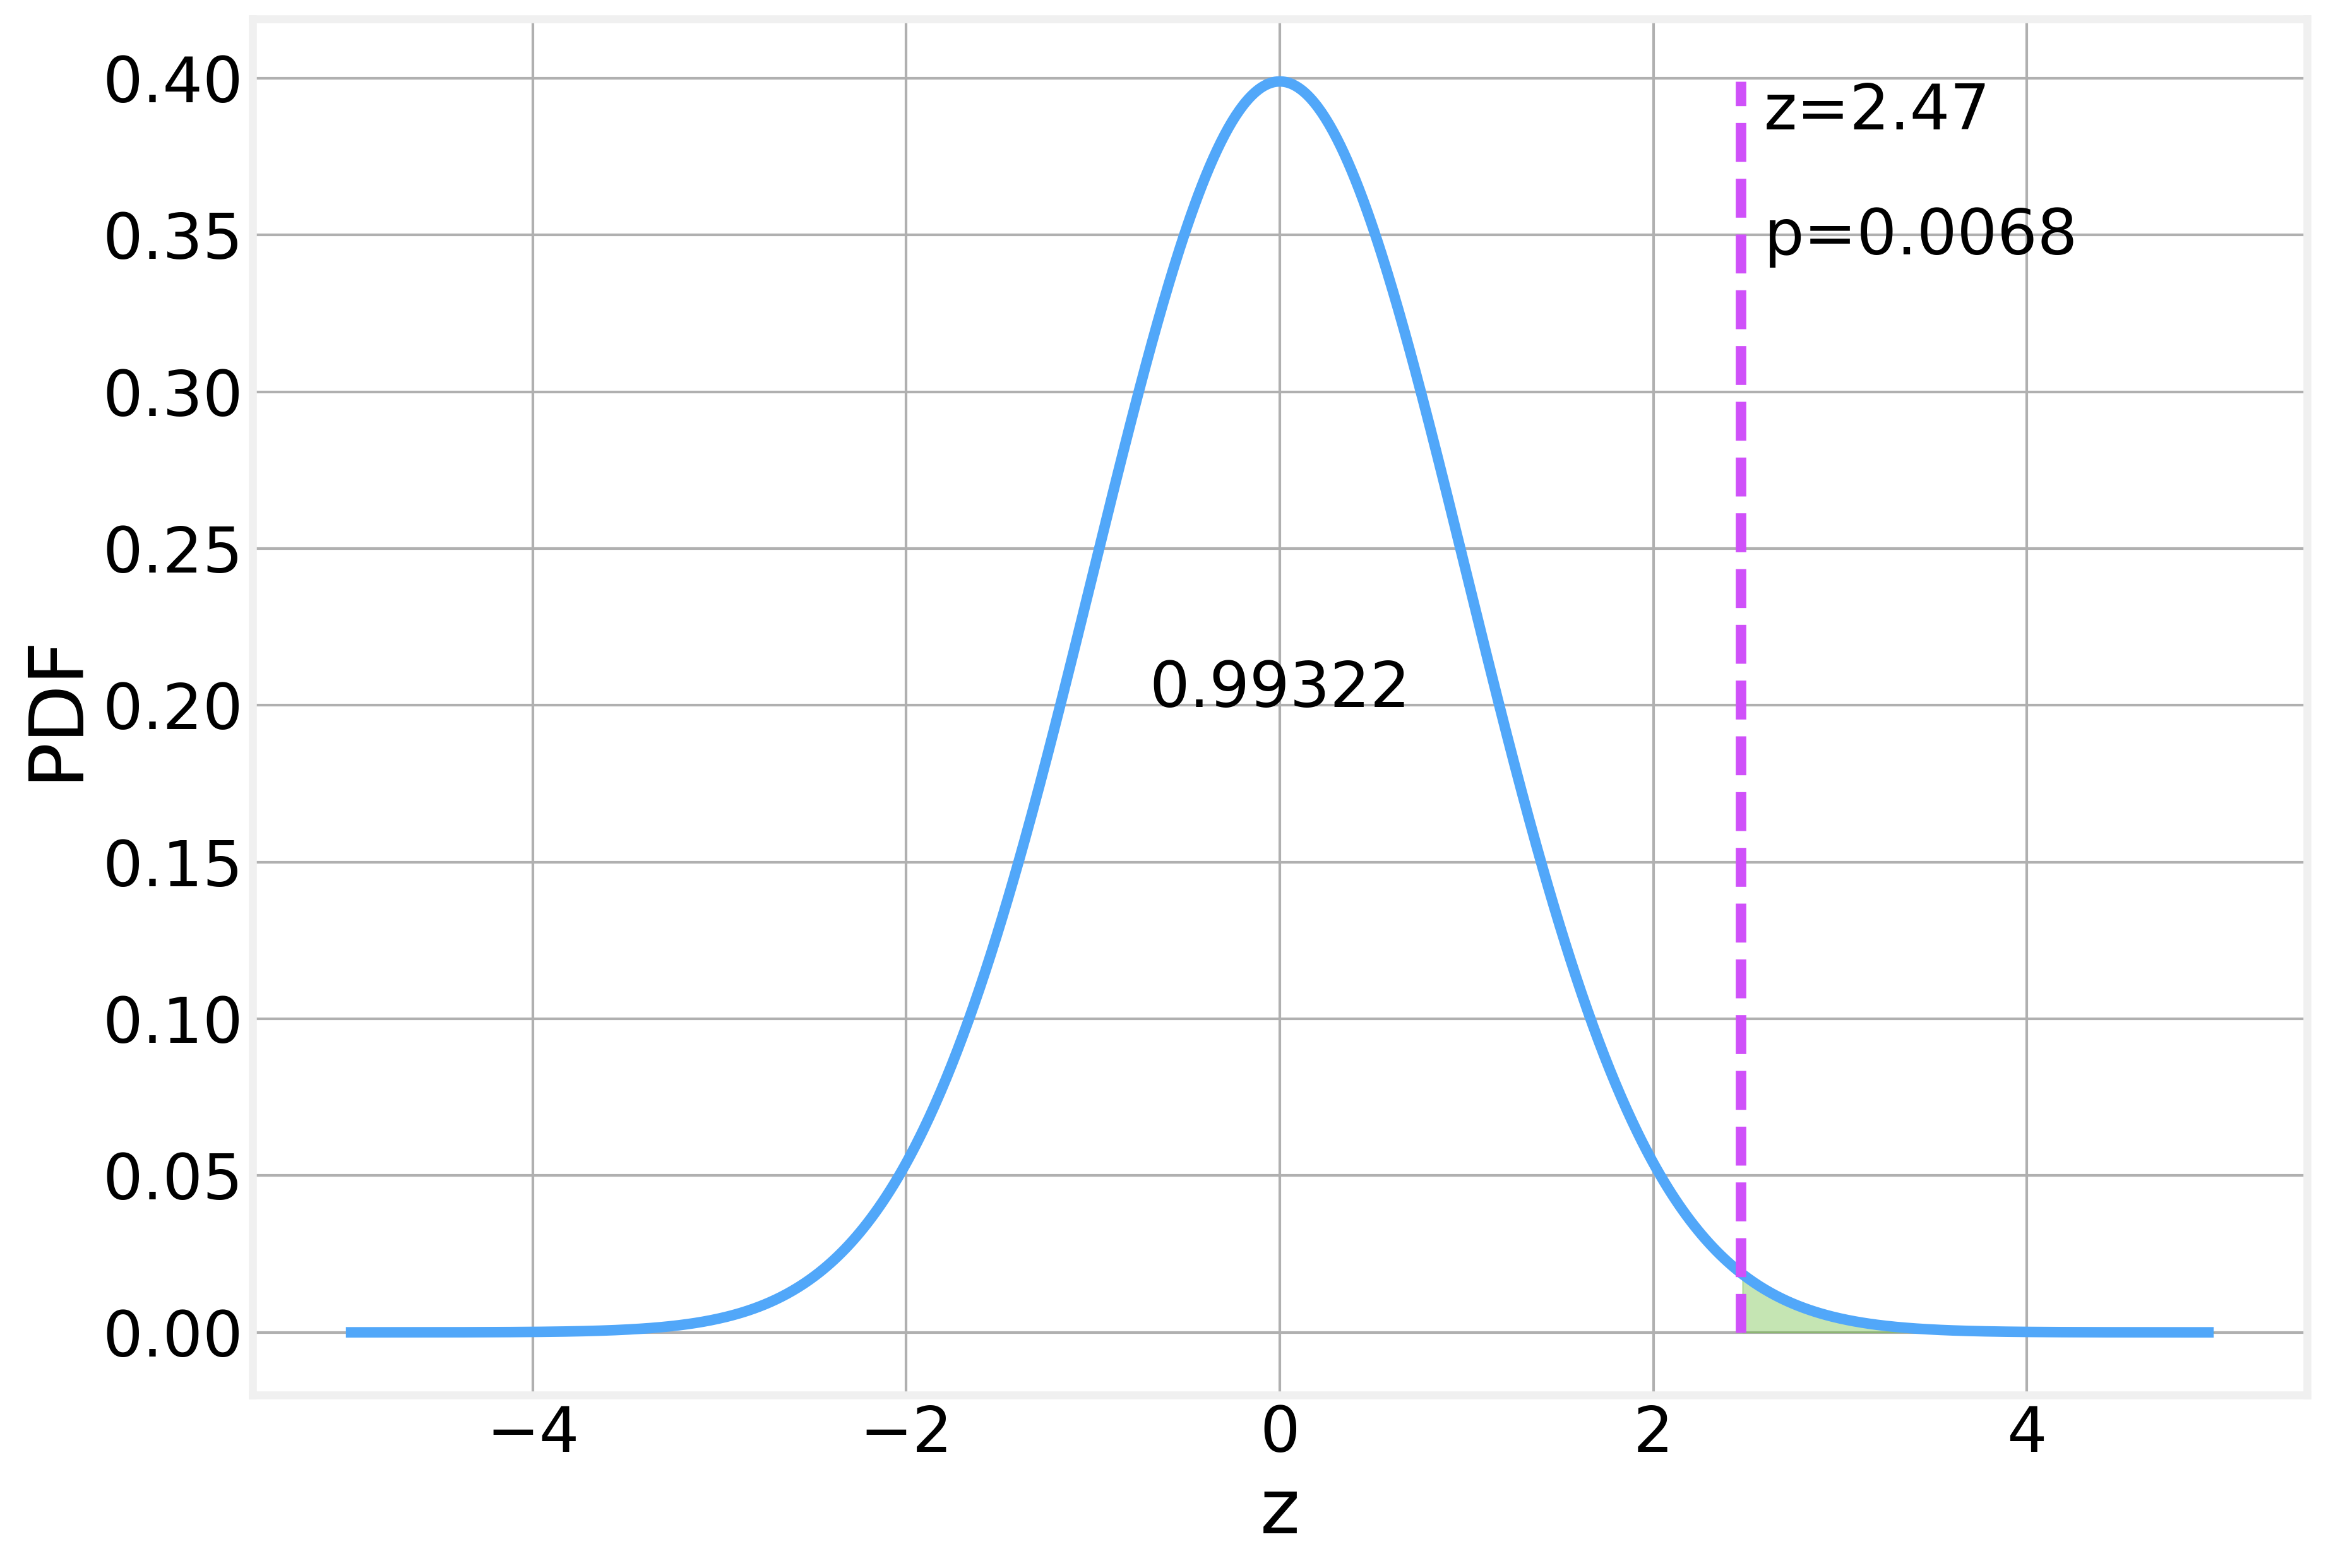

In [16]:
plot_zscore(Z)

## Simpson's Paradox

### Load the iris dataset 

In [17]:
iris = pd.read_csv('data/iris.csv')

In [18]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Split the dataset across species for convenience

In [19]:
setosa = iris[['sepal_width', 'petal_width']][iris['species'] == 'setosa']
versicolor = iris[['sepal_width', 'petal_width']][iris['species'] == 'versicolor']
virginica = iris[['sepal_width', 'petal_width']][iris['species'] == 'virginica']

### Perform the fits

In [20]:
lm_setosa = LinearRegression()
lm_setosa.fit(setosa['sepal_width'].values.reshape(-1,1), setosa['petal_width'])
y_setosa = lm_setosa.predict(setosa['sepal_width'].values.reshape(-1,1))

lm_versicolor = LinearRegression()
lm_versicolor.fit(versicolor['sepal_width'].values.reshape(-1,1), versicolor['petal_width'])
y_versicolor = lm_versicolor.predict(versicolor['sepal_width'].values.reshape(-1,1))

lm_virginica = LinearRegression()
lm_virginica.fit(virginica['sepal_width'].values.reshape(-1,1), virginica['petal_width'])
y_virginica = lm_virginica.predict(virginica['sepal_width'].values.reshape(-1,1))

lm_full = LinearRegression()
lm_full.fit(iris['sepal_width'].values.reshape(-1,1), iris['petal_width'])
y_full = lm_full.predict(iris['sepal_width'].values.reshape(-1,1))

### Generate the plot

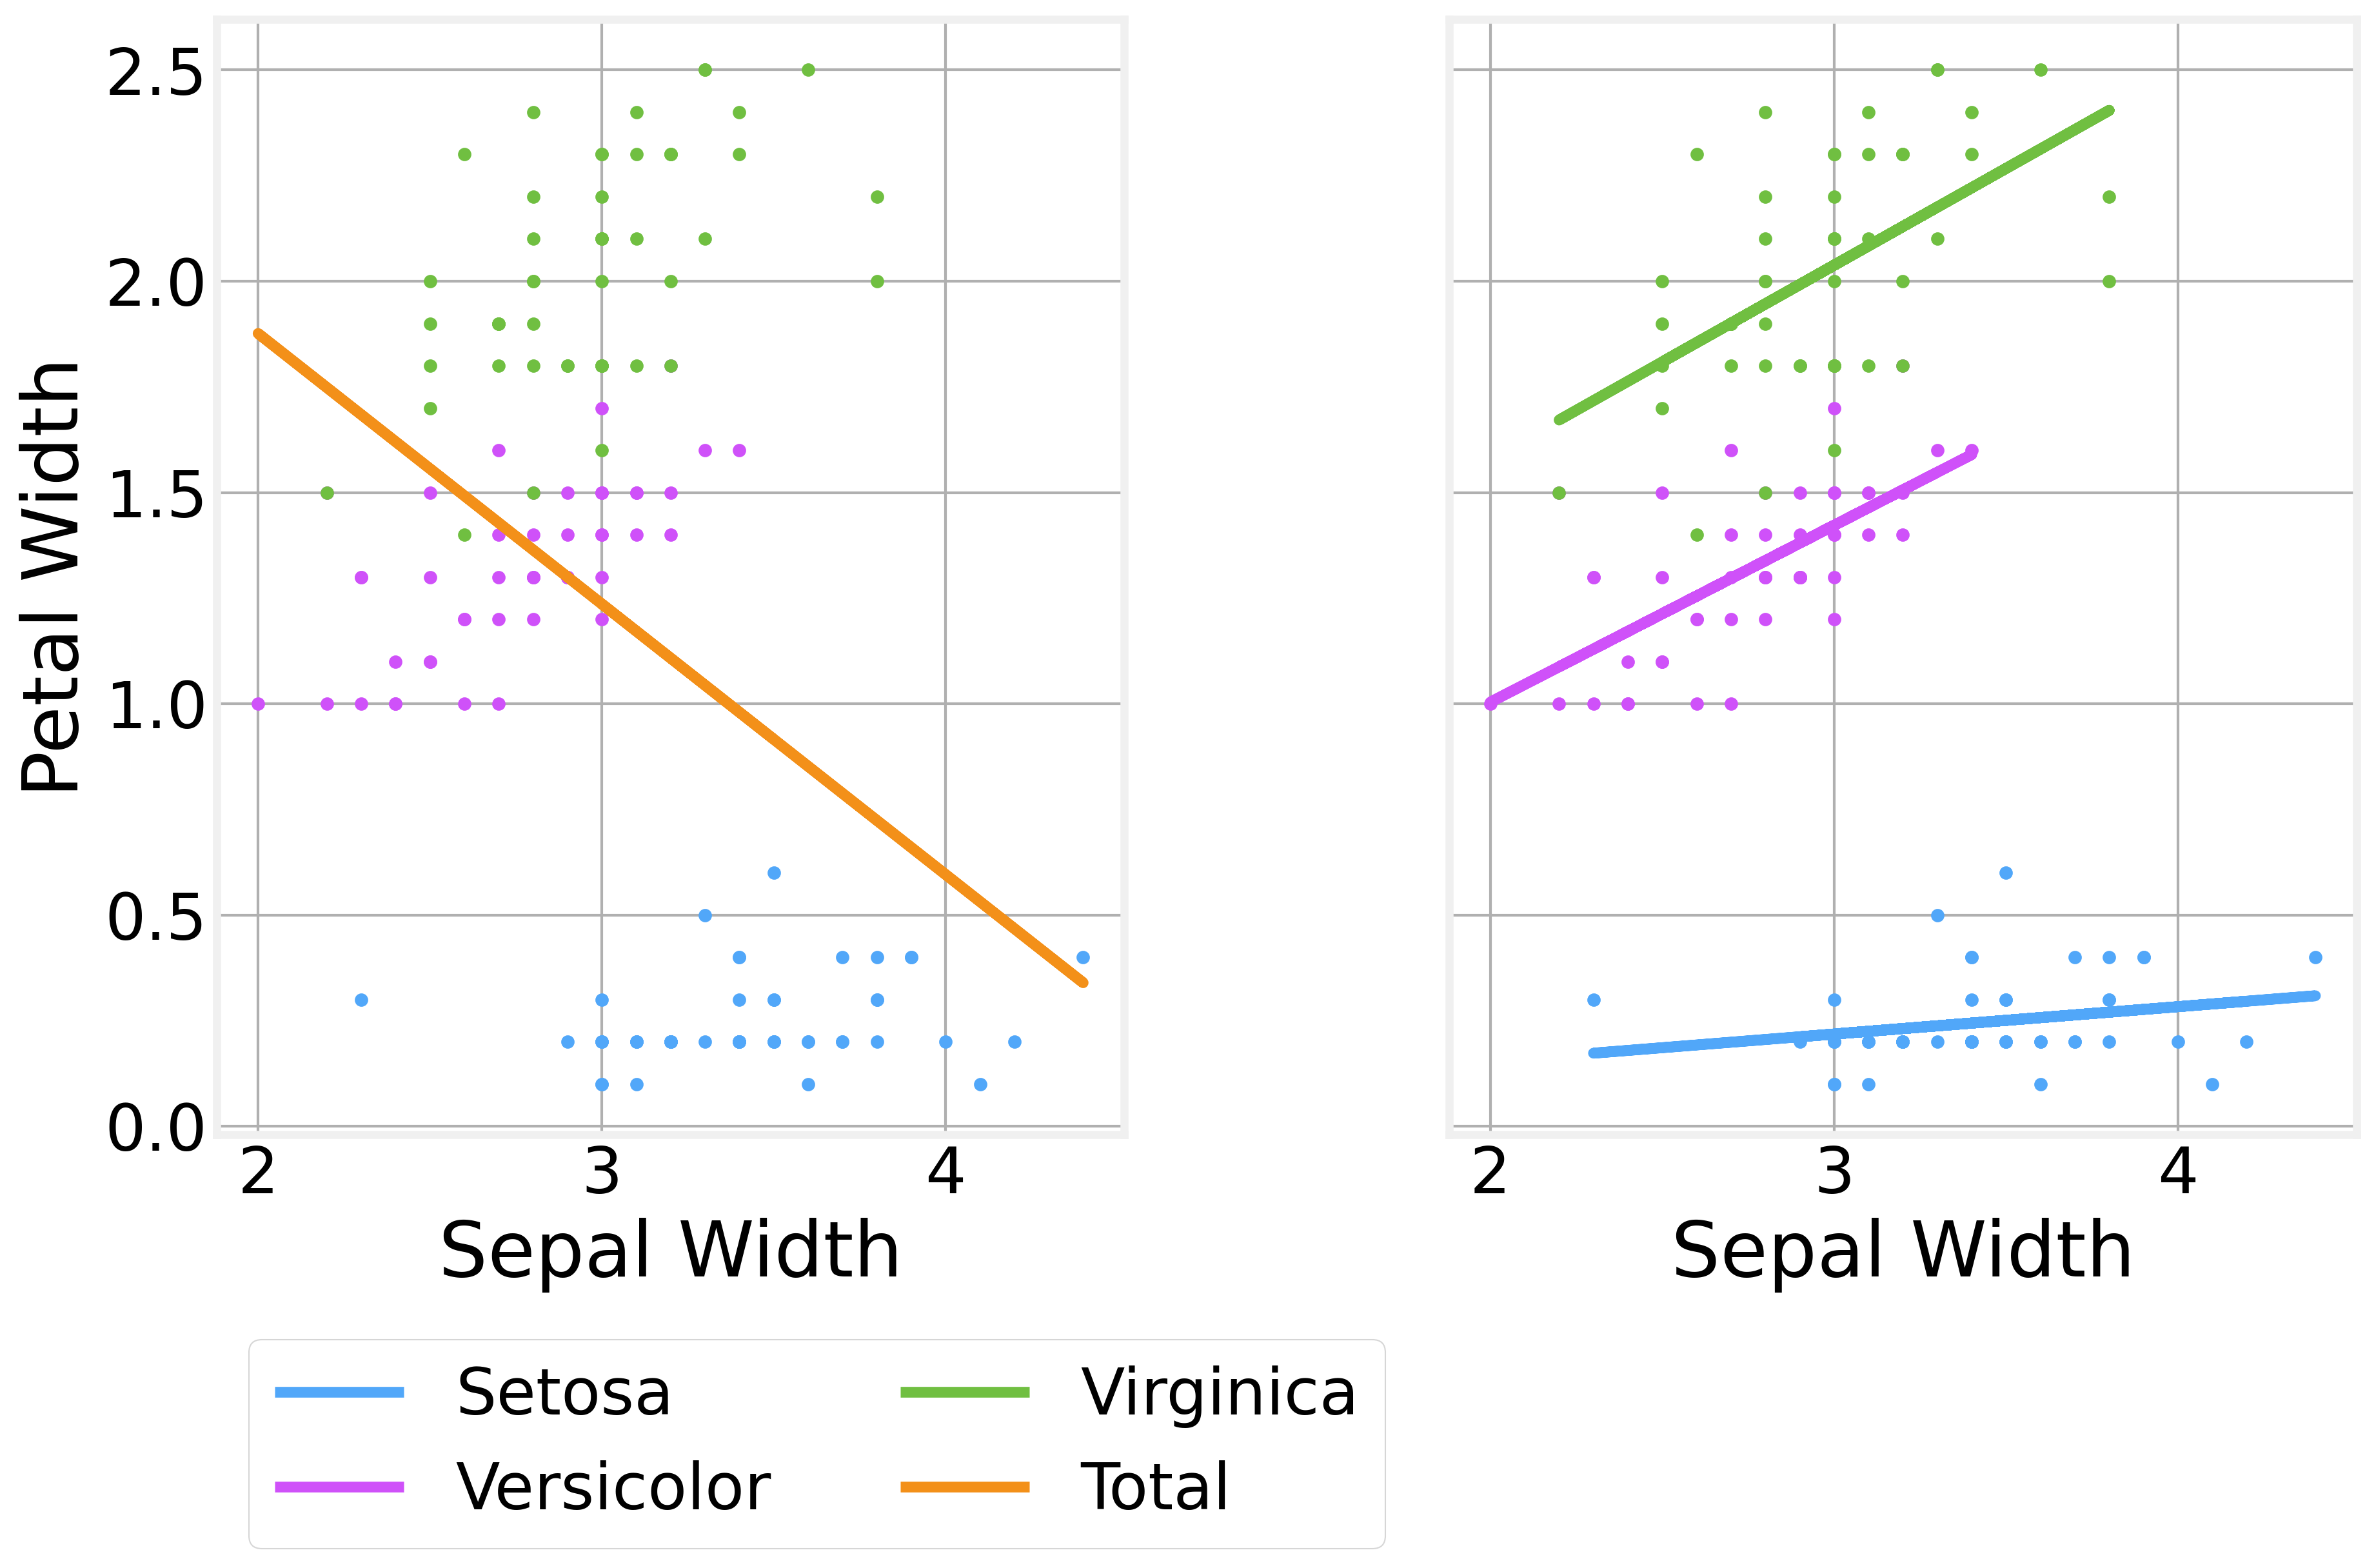

In [21]:
fig, axs = plt.subplots(ncols=2, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

setosa.plot.scatter(x='sepal_width', y='petal_width', label='setosa', ax=axs[0], c=colors[0])
versicolor.plot.scatter(x='sepal_width', y='petal_width', label='versicolor', ax=axs[0], c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', label='virginica', ax=axs[0], c=colors[2])
l4, = axs[0].plot(iris['sepal_width'].values.reshape(-1,1), y_full, '-', c=colors[3])

setosa.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[0])
versicolor.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', ax=axs[1], c=colors[2])

l1, = axs[1].plot(setosa['sepal_width'].values.reshape(-1,1), y_setosa, '-', c=colors[0])
l2, = axs[1].plot(versicolor['sepal_width'].values.reshape(-1,1), y_versicolor, '-', c=colors[1])
l3, = axs[1].plot(virginica['sepal_width'].values.reshape(-1,1), y_virginica, '-', c=colors[2])

axs[0].set_xlabel('Sepal Width')
axs[1].set_xlabel('Sepal Width')
axs[0].set_ylabel('Petal Width')

fig.subplots_adjust(bottom=0.3, wspace=0.33)

axs[0].legend(handles = [l1, l2, l3, l4] , labels=['Setosa', 'Versicolor', 'Virginica', 'Total'],
             loc='lower left', bbox_to_anchor=(0, -0.4), ncol=2, fancybox=True, shadow=False)

### Removing setosa

In [22]:
reduced = iris[iris['species'] != 'setosa'].copy()

In [23]:
lm_reduced = LinearRegression()
lm_reduced.fit(reduced['sepal_width'].values.reshape(-1,1), reduced['petal_width'])
y_reduced = lm_reduced.predict(reduced['sepal_width'].values.reshape(-1,1))

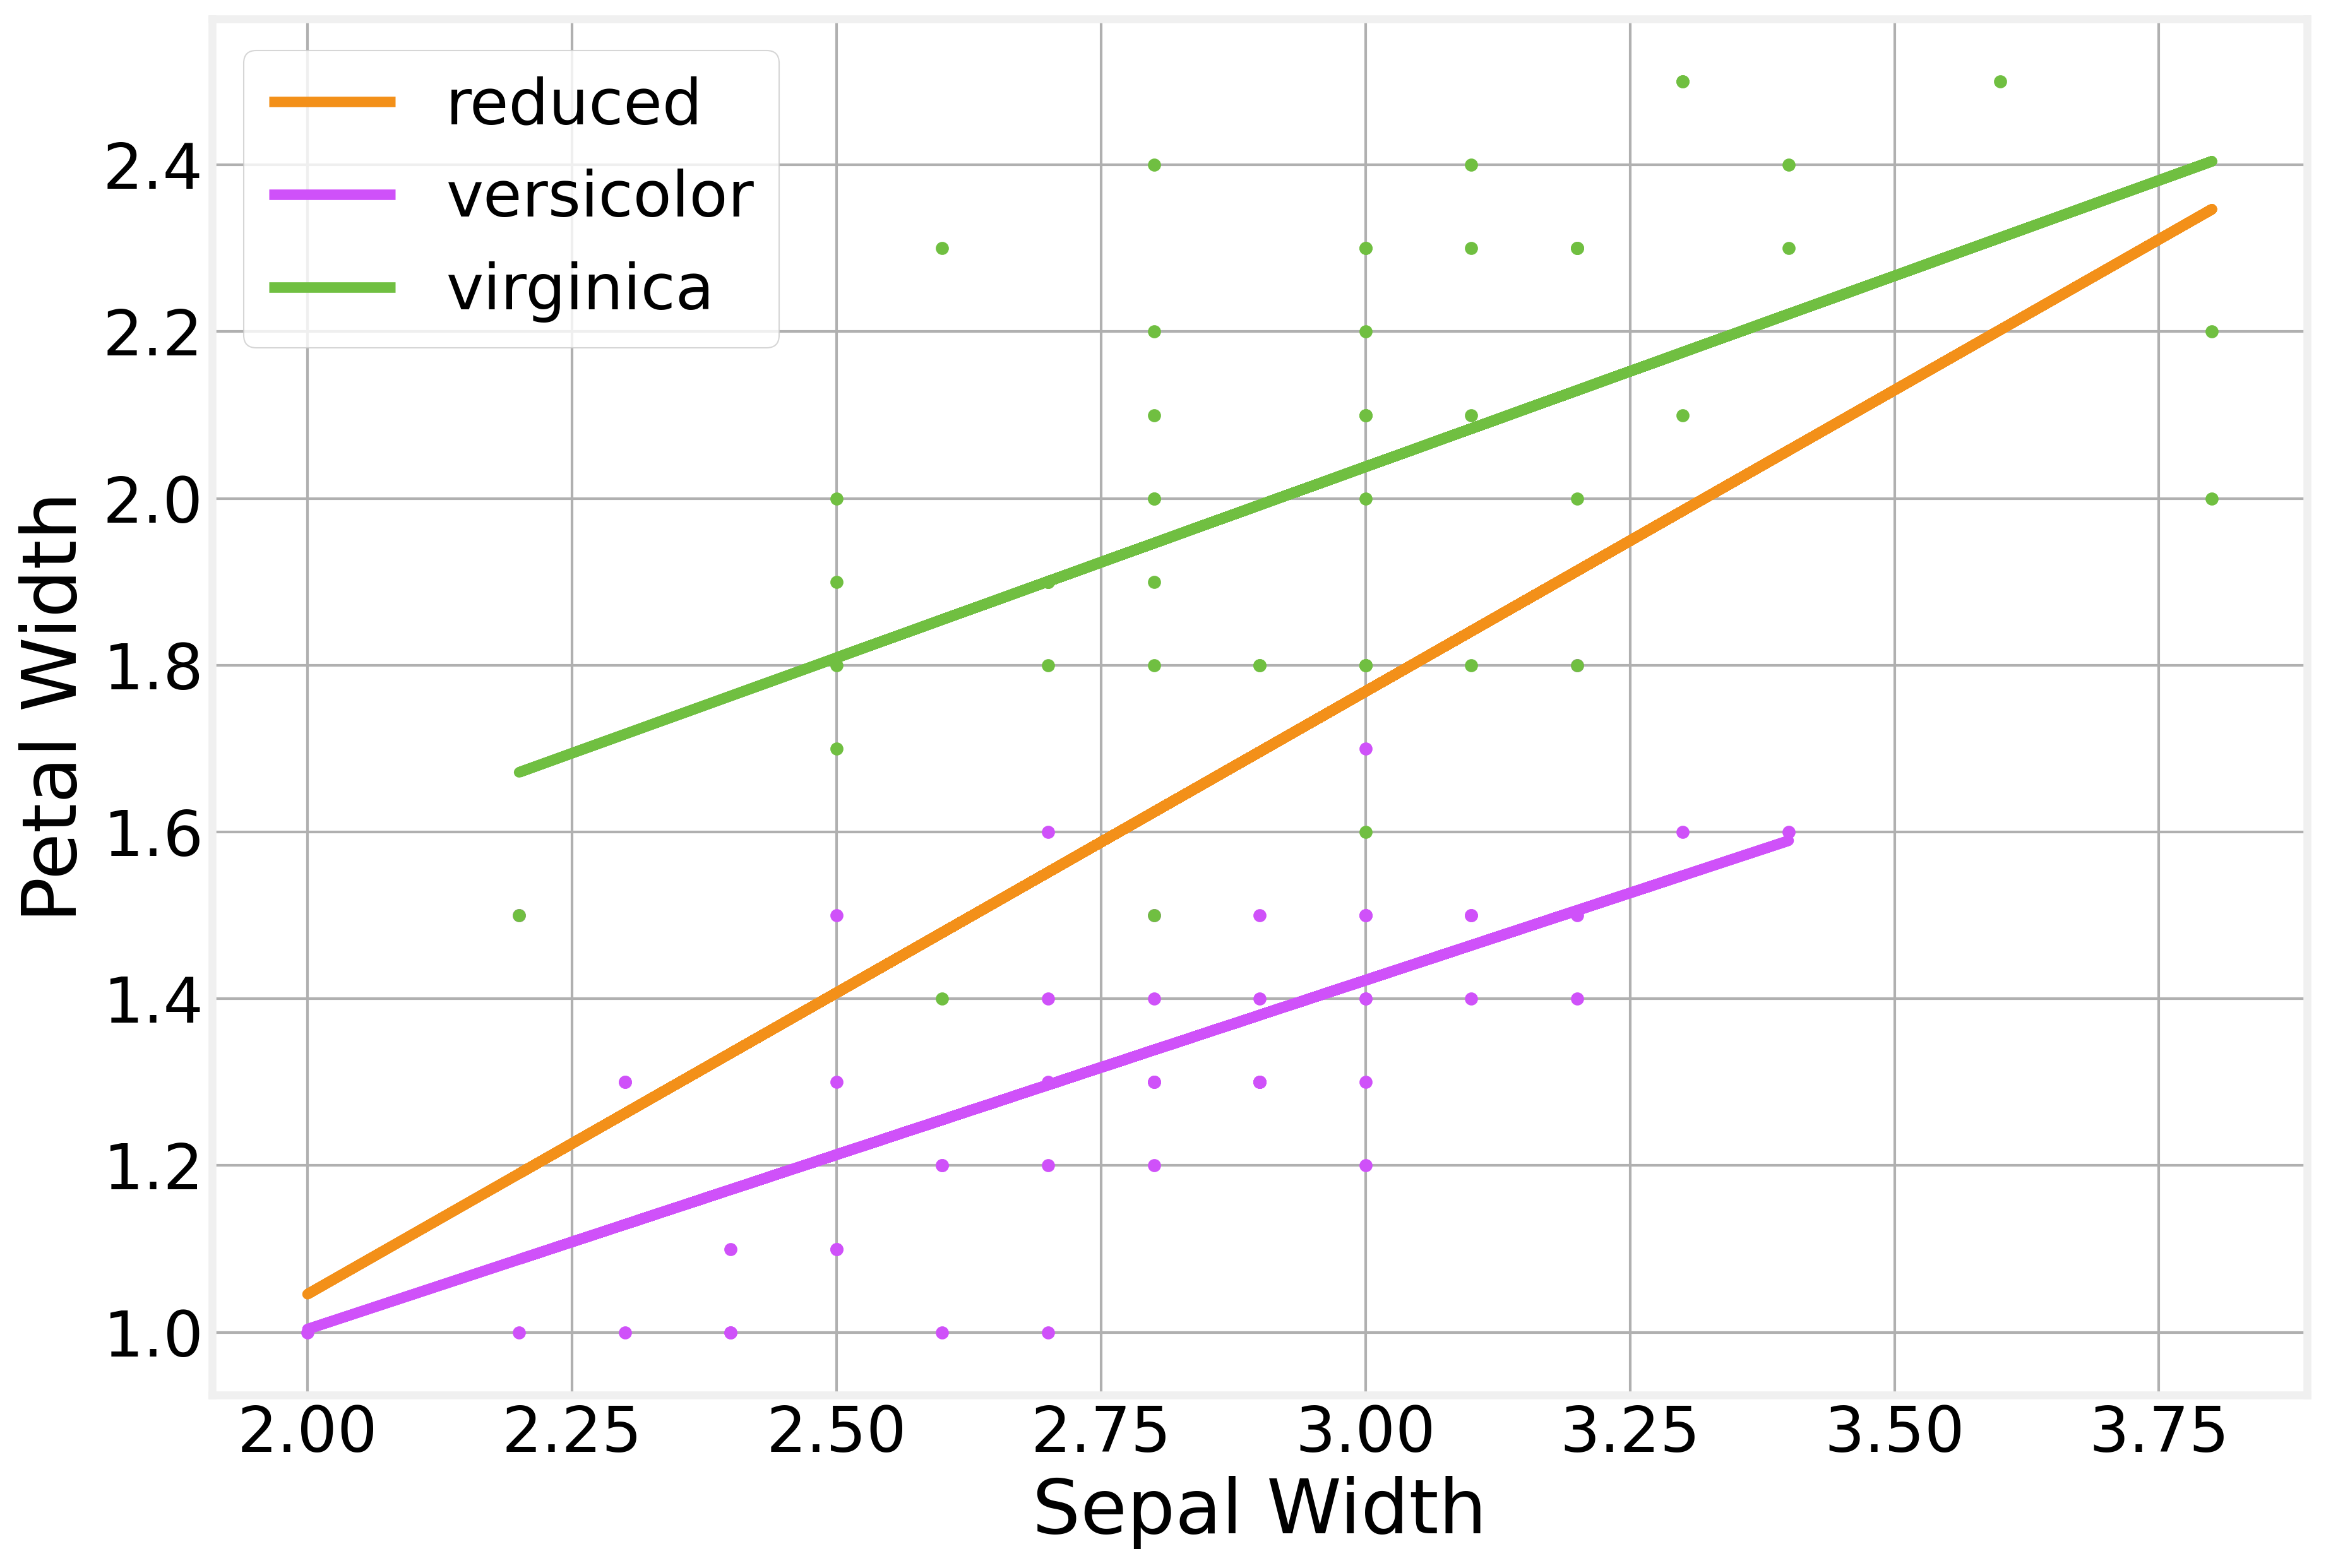

In [24]:
fig, axs = plt.subplots(ncols=1, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

versicolor.plot.scatter(x='sepal_width', y='petal_width', ax=axs, c=colors[1])
virginica.plot.scatter(x='sepal_width', y='petal_width', ax=axs, c=colors[2])
axs.plot(reduced['sepal_width'].values.reshape(-1,1), y_reduced, '-', c=colors[3], label='reduced')
axs.plot(versicolor['sepal_width'].values.reshape(-1,1), y_versicolor, '-', c=colors[1], label='versicolor')
axs.plot(virginica['sepal_width'].values.reshape(-1,1), y_virginica, '-', c=colors[2], label='virginica')

axs.set_xlabel('Sepal Width')
axs.set_ylabel('Petal Width')
plt.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>